**Libraries**

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import csv

**Variables**

In [187]:
look_back = 30
df = pd.read_csv('all_stationaries_data.csv')
results = []
res = [] ## for save data as a dataframe


**Bollinger Band Strategy**

In [188]:
def Bolinger_Band_Strategy(prices,initial_cap = 10000):
    
    ## My Portfolio History
    history = {'Date': [], 'Position': [], 'Status': [], 'Shares': [], 'Balance': []}
    
    ## initilizing
    balance = initial_cap
    shares = 0
    history['Date'].append(df['Date'][0])
    history['Position'].append('Start')
    history['Status'].append('Start')
    history['Balance'].append(balance)
    history['Shares'].append(shares)

    ## SMA and STD
    df['sma'] = df[prices].rolling(window=look_back).mean()
    df['std'] = df[prices].rolling(window=look_back).std()

    ## Buy Conditions
    buy_entry1 = df['sma'] - df['std'] * 2
    buy_entry2 = df['sma'] - df['std'] * 4
    buy_flag = False
    buy_exit = df['sma'] - df['std']

    ## Sell Conditions
    sell_entry1 = df['sma'] + df['std'] * 4
    sell_entry2 = df['sma'] + df['std'] * 4
    sell_flag = False
    sell_exit = df['sma'] + df['std']

    for i in range(29, 366):

        ## Buy Position
        if df[prices][i] <= buy_entry1[i] and df[prices][i] > buy_entry2[i] and shares == 0:
            buyable_share = balance / df[prices][i]
            shares += (buyable_share / 2)
            balance -= (shares * df[prices][i])
            history['Date'].append(df['Date'][i])
            history['Position'].append('Buy')
            history['Status'].append('Entry 1')
            history['Balance'].append(balance)
            history['Shares'].append(shares)

        elif df[prices][i] <= buy_entry2[i] and not buy_flag:
            buyable_share = balance / df[prices][i]
            shares += (buyable_share / 2)
            balance -= ((buyable_share / 2) * df[prices][i])
            buy_flag = True
            history['Date'].append(df['Date'][i])
            history['Position'].append('Buy')
            history['Status'].append('Entry 2')
            history['Balance'].append(balance)
            history['Shares'].append(shares)

        elif df[prices][i] < df['sma'][i] and df[prices][i] > buy_exit[i] and buy_flag:
            balance += (shares * df[prices][i])
            shares = 0
            buy_flag = False
            history['Date'].append(df['Date'][i])
            history['Position'].append('Buy')
            history['Status'].append('Exit')
            history['Balance'].append(balance)
            history['Shares'].append(shares)
 

        ## Sell Position
        elif df[prices][i] >= sell_entry1[i] and df[prices][i] < sell_entry2[i] and shares != 0:
            sellable_share = balance / df[prices][i]
            shares -= sellable_share / 2
            balance += (sellable_share * df[prices][i])
            history['Date'].append(df['Date'][i])
            history['Position'].append('Sell')
            history['Status'].append('Entry 1')
            history['Balance'].append(balance)
            history['Shares'].append(shares)

        elif df[prices][i] >= sell_entry2[i] and shares != 0  and not sell_flag:
            sellable_share = balance / df[prices][i]
            shares -= sellable_share / 2
            balance += (sellable_share * df[prices][i])
            sell_flag = True
            history['Date'].append(df['Date'][i])
            history['Position'].append('Sell')
            history['Status'].append('Entry 2')
            history['Balance'].append(balance)
            history['Shares'].append(shares)
        
        elif df[prices][i] <= sell_exit[i] and df[prices][i] > df['sma'][i] and sell_flag:
            balance -= (shares * df[prices][i])
            shares = 0
            sell_flag = False
            history['Date'].append(df['Date'][i])
            history['Position'].append('Sell')
            history['Status'].append('Exit')
            history['Balance'].append(balance)
            history['Shares'].append(shares)
    
    ## Exit all the trades we are in at the end of the range
    length = len(history['Balance'])
    if history['Position'][length - 1] != 'Exit':
        balance += (shares * df[prices][365])
        shares = 0 
        history['Date'].append('11/01/2023')
        history['Position'].append('CLOSE TRADES')
        history['Status'].append('CLOSE')
        history['Balance'].append(balance)
        history['Shares'].append(shares)


    return history

In [189]:
for i in range(1,11):
    hist = Bolinger_Band_Strategy(f'Stationary{i}')
    results.append(hist)
    res.append(pd.DataFrame(hist))

**Sharpe Ratio**

In [190]:
## Source1 : https://www.kaggle.com/code/jaakkokivisto/pandas-tutorial-for-finance-bigtech-sharpe-ratios
## Source2 : https://www.codearmo.com/blog/sharpe-sortino-and-calmar-ratios-python
def Sharp_Ratio(backtest):
    # backtest_df = pd.DataFrame(backtest['Balance'])
    returns = backtest.pct_change().dropna()
    risk_free = (1.02**(1/360))-1 
    mean = returns.mean()
    vol = returns.std()
    sharp_ratio = (mean - risk_free) / vol
    return sharp_ratio


In [191]:
for i in range(10):
    backtest_df = pd.DataFrame(results[i]['Balance'])
    sharp_ratio = Sharp_Ratio(backtest_df)
    print(sharp_ratio.values[0])

0.23042714306745282
0.3228378920634162
0.23042877875564624
0.3257619462321442
0.36526052733792364
0.230181912076044
0.2723065486357227
0.22078323833579466
0.2537135348906022
0.2304997199329152


**Equity Curve**

In [192]:
def convert_to_df(data):
    df = data.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    # Create date range
    start_date = datetime(2022, 11, 1)
    end_date = datetime(2023, 11, 1)
    all_dates = pd.date_range(start_date, end_date)

    # Set Date as the index of df for easier manipulation
    df.set_index('Date', inplace=True)

    # Reindex df to include all dates in the date range
    df = df.reindex(all_dates)

    # Forward fill Balance to propagate the last valid observation forward
    df['Balance'] = df['Balance'].ffill()

    # Reset the index
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Date'}, inplace=True)
    df = df[['Date', 'Balance']]
    return df

In [193]:
## Source : https://www.investopedia.com/terms/e/equity-curve.asp#:~:text=An%20equity%20curve%20is%20a,are%20generating%20a%20negative%20return.
def calculate_equity(df, initial_cap=10000):
    equity = [initial_cap]
    for i in range(len(df)):
        equity.append(df['Balance'].iloc[i])
    return equity
equity = calculate_equity(res[1])

Stationary1


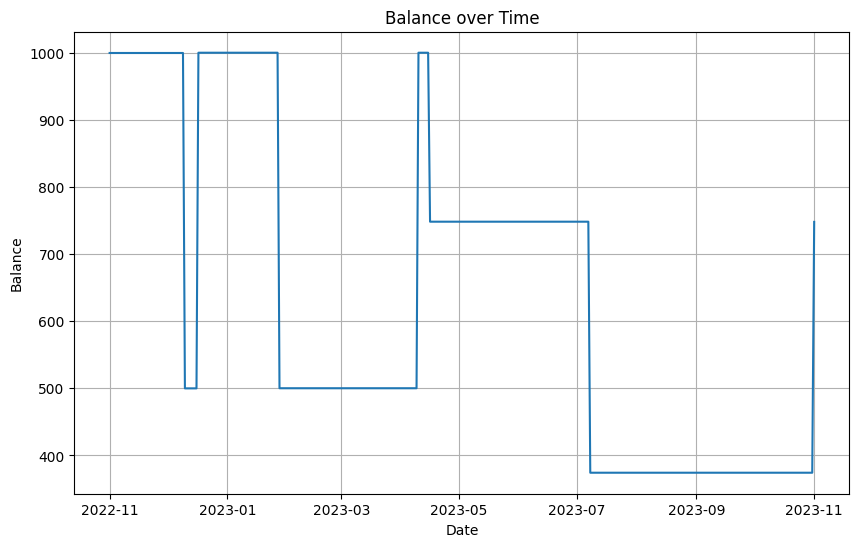

------------------------------------------------------------
Stationary2


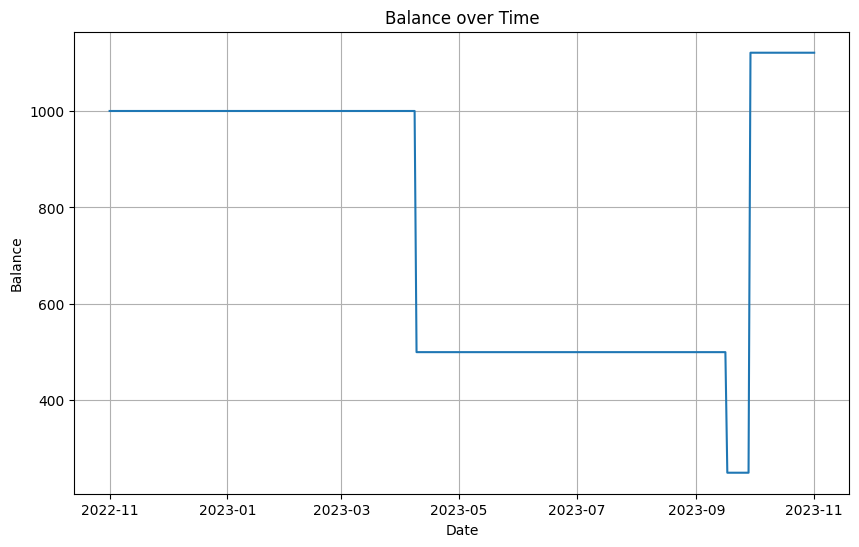

------------------------------------------------------------
Stationary3


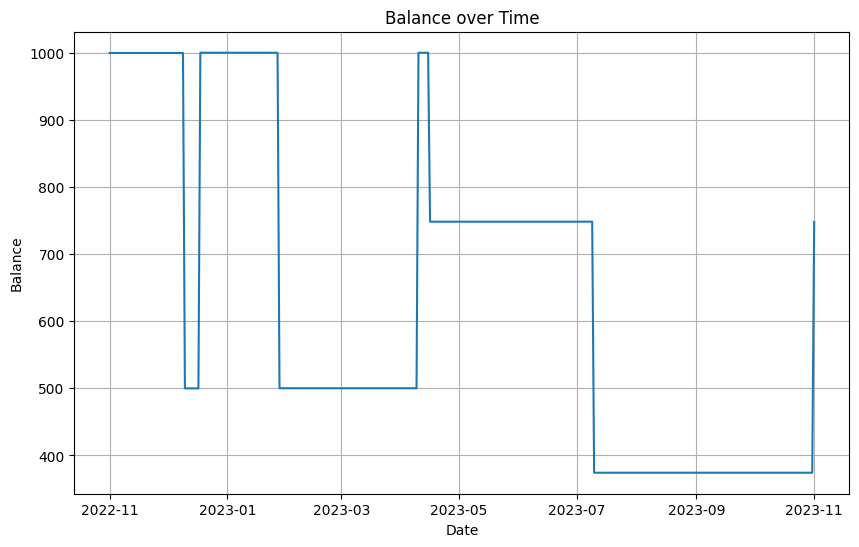

------------------------------------------------------------
Stationary4


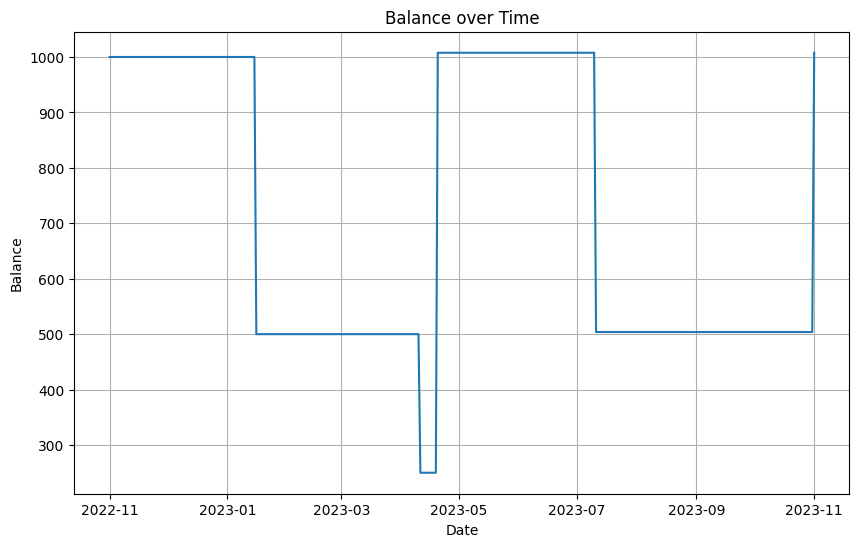

------------------------------------------------------------
Stationary5


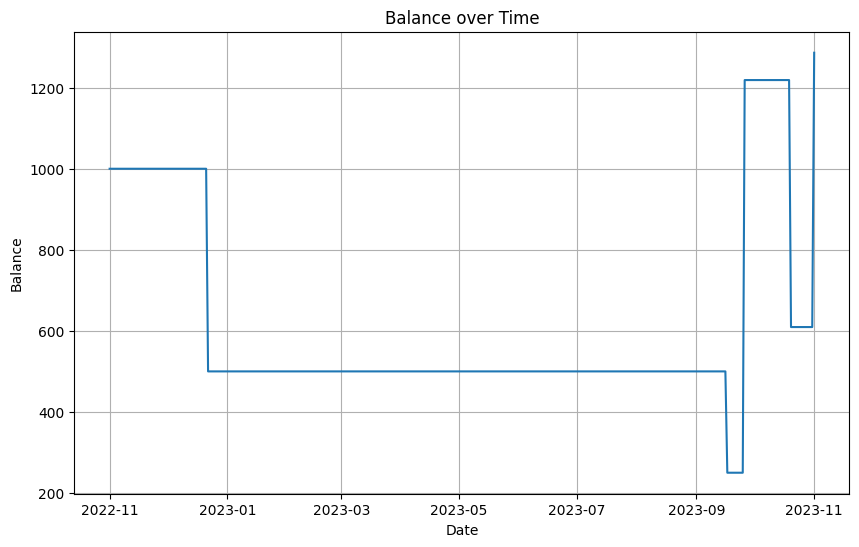

------------------------------------------------------------
Stationary6


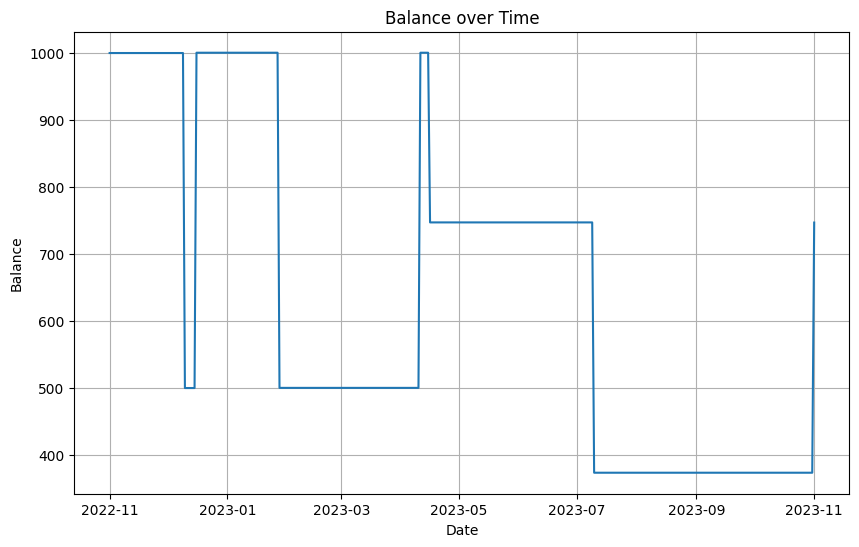

------------------------------------------------------------
Stationary7


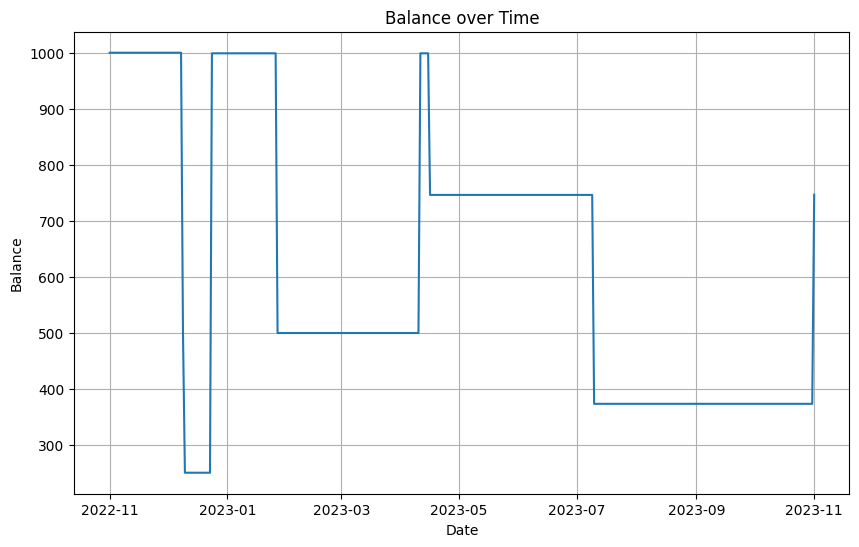

------------------------------------------------------------
Stationary8


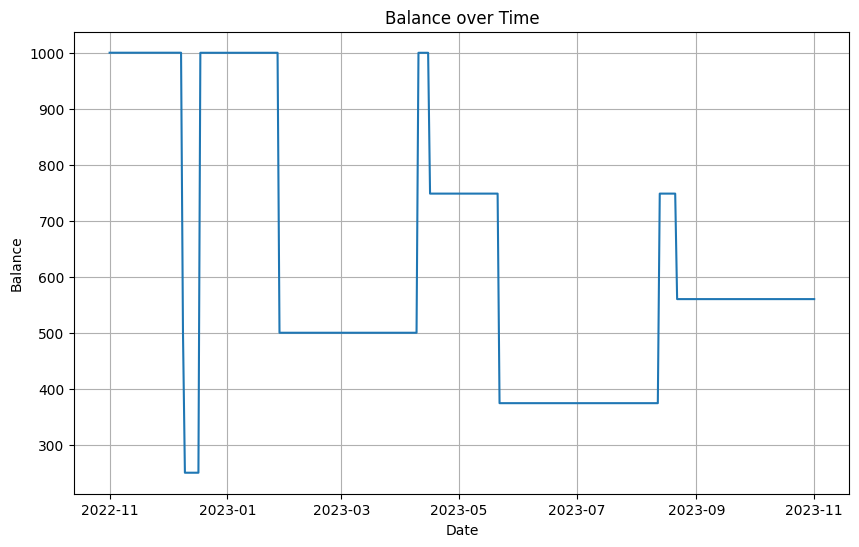

------------------------------------------------------------
Stationary9


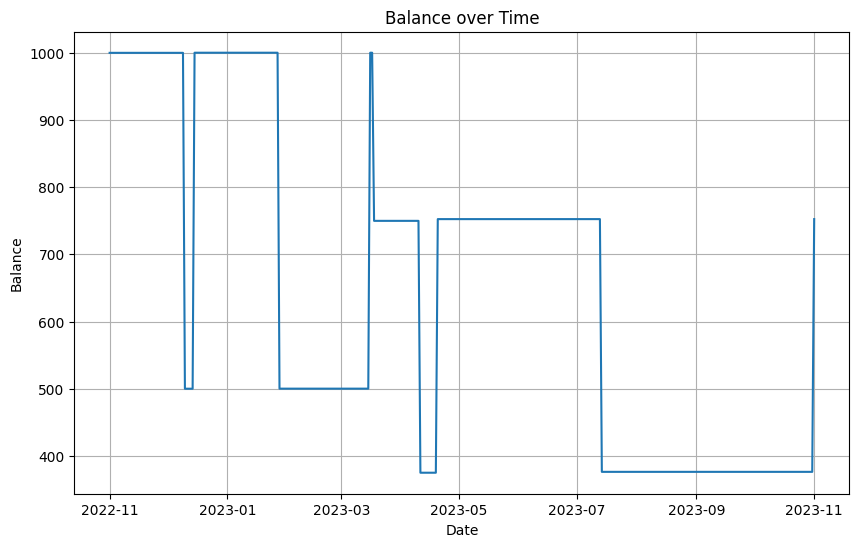

------------------------------------------------------------
Stationary10


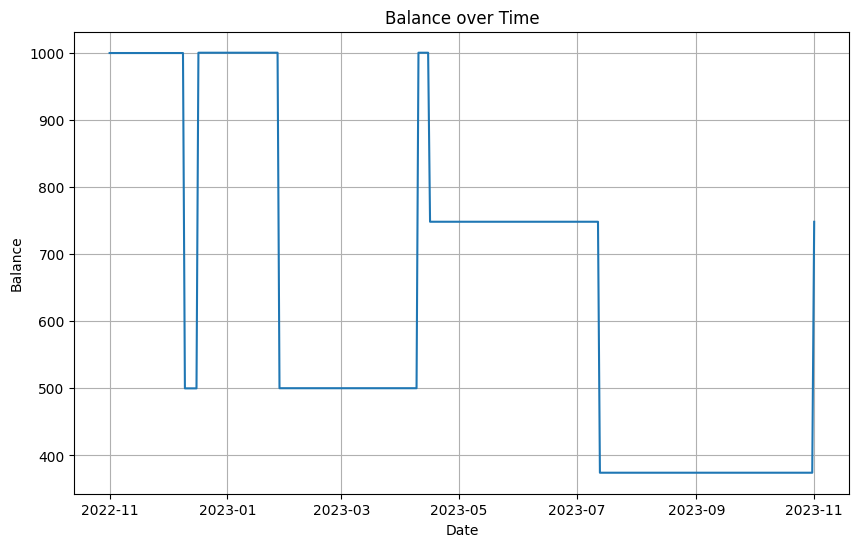

------------------------------------------------------------


In [194]:
for i in range(10):
    df = convert_to_df(res[i])
    plt.figure(figsize=(10, 6))
    print(f'Stationary{i+1}')
    plt.plot(df['Date'], df['Balance'])
    plt.title('Balance over Time')
    plt.xlabel('Date')
    plt.ylabel('Balance')
    plt.grid(True)
    plt.show()
    print('------------------------------------------------------------')